In [ ]:
# RFM 출처 : https://medium.com/@nurlan.imanov/customer-segmentation-using-rfm-analysis-d2df1dfa2f9f
# OOO 출처 : https://assaeunji.github.io/statistics/2022-04-15-ltv/

목적 
+ RMF 고객등급 분류
+ 각 등급별 방문횟수/구매금액/미래방문횟수/미래구매금액 표기


지표
+ RMF : 고객등급 분류 $\to$ VIP 산정방식 고려
+ BG/NBD 모형 : 미래 구매횟수
+ Gamma/Gamma 모형 : 미래 구매 금액 $\to$ 쿠폰금액 결정

1. 데이터 불러오기
2. RMF 분류
3. 예측값 모델링
  + BG/NBD 모형
  + Gamma/Gamma 모형
4. 관련 내용 설명(예시)

In [1]:
# DB접속
import os
from os import listdir
import cx_Oracle as oci
import numpy as np
import pandas as pd

from datetime import datetime, timedelta

# 그래프
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)


In [2]:
# DB접속 : 접속정보 읽기
con_text = open("C:/Users/MAEIL/conn_info_MMBSHIP.txt", 'r', encoding='utf8')
con_text = con_text.read()

# DB 접속 : 실제 접속
conn = oci.connect(con_text[1:], encoding='UTF-8', nencoding='UTF-8')

### 1.데이터 불러오기

In [3]:
###############
# 1.데이터 불러오기 : 최근 12개월간,쿠폰 이용
#####

# query run
query1 = '''
    with employee_list as 
        ( select distinct unfy_mmb_no, 'Y' as gubun
        from mmbship.tpr_crd_mstr
        where crd_kind = '998')

    --쿠폰 사용
    select I.unfy_mmb_no
    , '쿠폰 사용' as TRSC_TYP_CD , U.coopco_CD, U.dc_amt as USE_AMT, U.dc_tgt_amt as TOT_SEL_AMT, U.reg_dtm as reg_dtm
    , (case when round((TRUNC(sysdate,'YY') - TO_DATE(btdy, 'YYYYMMDD'))/365,0) > 100 then 45 else  round((TRUNC(sysdate,'YY') - TO_DATE(btdy, 'YYYYMMDD'))/365,0) end) as age
    , (case when E.gubun is null then 'N' else E.gubun end) as gubun
    from mmbship.tpm_cpn_use U, mmbship.tpm_cpn_issu C, employee_list E, tm_mmb_info I
    where C.unfy_mmb_no = I.unfy_mmb_no 
    and C.unfy_mmb_no = E.unfy_mmb_no(+)
    and C.cpn_issu_cd = U.cpn_issu_cd
    and C.cpn_st_Cd = '2'
    and U.coopco_CD in ('7050', '7060') 
    and I.mmb_st_cd = '1'
    and C.unfy_mmb_no not in ('443986')
    and to_char(U.reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
    --and U.reg_dtm between ADD_MONTHS( TRUNC(sysdate,'MM'), -7 ) and ADD_MONTHS( LAST_DAY(sysdate), -1 )           
    union all
    --포인트 적립/사용
    select T.unfy_mmb_no
    , (select code_nm from mmbship.JT_CODE where code_grp_id = 'PM001' and trsc_typ_cd = code) as trsc_typ_cd
    , T.coopco_cd, (case when acml_pint = 0 then use_pint else acml_pint end) as use_amt , T.tot_sel_amt, T.reg_dtm as reg_dtm
    , (case when round((TRUNC(sysdate,'YY') - TO_DATE(btdy, 'YYYYMMDD'))/365,0) > 100 then 45 else  round((TRUNC(sysdate,'YY') - TO_DATE(btdy, 'YYYYMMDD'))/365,0) end) as age
    , (case when E.gubun is null then 'N' else E.gubun end) as gubun
    from mmbship.TP_TRSC_PTCL T, employee_list E, tm_mmb_info I
    where T.unfy_mmb_no is not null 
    and T.tot_sel_amt > 0 
    and T.unfy_mmb_no = I.unfy_mmb_no 
    and I.mmb_st_cd = '1'
    and T.unfy_mmb_no = E.unfy_mmb_no(+)
    and to_char(T.reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
    --and T.reg_dtm between ADD_MONTHS( TRUNC(sysdate,'MM'), -7 ) and ADD_MONTHS( LAST_DAY(sysdate), -1 )
    and T.trsc_typ_cd in ( '200', '300')
    and T.COOPCO_CD in ('7050', '7060')
    union all
    --기프트카드사용
    select T.unfy_mmb_no
    , (select code_nm from mmbship.JT_CODE where code_grp_id = 'PM001' and trsc_typ_cd = code) as trsc_typ_cd
    , T.coopco_cd, H.use_amt, T.tot_sel_amt, T.reg_dtm as reg_dtm
    , (case when round((TRUNC(sysdate,'YY') - TO_DATE(btdy, 'YYYYMMDD'))/365,0) > 100 then 45 else  round((TRUNC(sysdate,'YY') - TO_DATE(btdy, 'YYYYMMDD'))/365,0) end) as age
    , (case when E.gubun is null then 'N' else E.gubun end) as gubun
    from mmbship.TP_TRSC_PTCL T, employee_list E, mmbship.tm_mmb_info I, mmbship.tpr_crd_actv_amt_use_hist H
    where T.unfy_mmb_no is not null 
    and T.tot_sel_amt > 0 
    and H.use_idx = T.apv_no
    and T.unfy_mmb_no = I.unfy_mmb_no 
    and I.mmb_st_cd = '1'
    and T.unfy_mmb_no = E.unfy_mmb_no(+)
    and to_char(T.reg_dtm, 'YYYY') = to_char(sysdate, 'YYYY')
    --and T.reg_dtm between ADD_MONTHS( TRUNC(sysdate,'MM'), -7 ) and ADD_MONTHS( LAST_DAY(sysdate), -1 )
    and T.trsc_typ_cd in ( 'G40')
    and T.COOPCO_CD in ('7050', '7060')
        '''
df_all = pd.read_sql(query1, con = conn )

df_all['UNFY_MMB_NO'] = df_all['UNFY_MMB_NO'].astype(object)

# 임직원 제외
df_all = df_all[df_all['GUBUN']=='N'].reset_index(drop=True)

In [4]:
print('- 해당인원 : {}'.format(len(df_all.UNFY_MMB_NO.unique())))
print('  + 최초   시점 : {}'.format(df_all.REG_DTM.min()))
print('  + 마지막 시점 : {}'.format(df_all.REG_DTM.max()))

- 해당인원 : 936
  + 최초   시점 : 2022-01-01 11:18:58
  + 마지막 시점 : 2022-08-21 19:28:02


In [5]:
# 분석 대상 관계사 지정
df = df_all[df_all.COOPCO_CD =='7050'].reset_index(drop=True)

### 2.RFM 계산

In [282]:
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler

from lifetimes.utils import summary_data_from_transaction_data

In [283]:
# df = df2.copy()

In [348]:
today_date = datetime(2022, 8, 1) # We have to set today date in order to calculate Recency metric
period_end_date = (datetime.today()+ timedelta(days=-1))
rfm = df.groupby('UNFY_MMB_NO').agg({'REG_DTM': lambda date: (period_end_date - date.max()).days, # Recency calclation
                                     'UNFY_MMB_NO': lambda num: num.count(), # Frequency calculation
                                     'TOT_SEL_AMT': lambda TotalPrice: TotalPrice.sum()}) # Monetary calculation

rfm.columns = ['Recency', 'Frequency', 'Monetary'] # Changing column names

# Converting
rfm['recency_score']   = pd.qcut(rfm['Recency'], 5, [5, 4, 3, 2,1])
rfm['frequency_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, [1, 2, 3, 4, 5]) 
rfm['monetary_score']  = pd.qcut(rfm['Monetary'], 5, [1, 2, 3, 4, 5]) 

# Calculating RFM score
rfm['RFM_SCORE'] = (rfm['recency_score'].astype('str') + rfm['frequency_score'].astype('str'))

seg_map = {
    r'[1-2][1-2]': '10.hibernating', # For instance means: If F is 1 or 2 and If R is 1 or 2 give hibernating 
    r'[1-2]5': '09.cant_loose',
    r'[1-2][3-4]': '08.at_Risk',
    r'3[1-2]': '07.about_to_sleep',
    r'33': '06.need_attention',
    r'41': '05.promising',
    r'51': '04.new_customers',
    r'[4-5][2-3]': '03.potential_loyalists',
    r'[3-4][4-5]': '02.loyal_customers',
    r'5[4-5]': '01.champions'
}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)

rfm2 = pd.merge(rfm, df[['UNFY_MMB_NO', 'AGE']].drop_duplicates(), left_on='UNFY_MMB_NO', right_on='UNFY_MMB_NO', how='left')


summary = summary_data_from_transaction_data(df, 'UNFY_MMB_NO', 'REG_DTM', observation_period_end=df.REG_DTM.max().strftime('%Y-%m-%d'))
summary = summary.reset_index()
rfm_lifetime = rfm2[['UNFY_MMB_NO', 'segment']]

summary = pd.merge( summary, rfm_lifetime, on ='UNFY_MMB_NO', how ='left')


'2022-08-08'

### 3.예측값 모델링

In [285]:
# Gamma/Gamma 모형 : 예상 사용금액 추정
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
data = summary.copy()

t = 15
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
BGF_15t = list(data.groupby('segment')['predicted_purchases'].mean())

t = 30
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
BGF_30t = list(data.groupby('segment')['predicted_purchases'].mean())


In [334]:
# Gamma/Gamma 모형 : 예상 사용금액 추정
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(rfm2['Frequency'], rfm2['Monetary'])

ggf.conditional_expected_average_profit(rfm2['Frequency'], rfm2['Monetary']).head(10)
ggf.conditional_expected_average_profit(rfm2['Frequency'], rfm2['Monetary']).sort_values(ascending=False).head(10)

rfm2["expected_average_profit"] = ggf.conditional_expected_average_profit(rfm2['Frequency'],rfm2['Monetary'])

In [339]:
# 최종 결과 정리

report_04 = pd.pivot_table(rfm2, 
                         values=['Monetary',  'Frequency', 'expected_average_profit','AGE'], 
                         index=['segment'],  
                         aggfunc=np.mean).fillna(0)


report_04 = report_04.reset_index()
report_04['Monetary(Pred.)'] = report_04['expected_average_profit'] - report_04['Monetary']
# df_sub3['BGF_15t'] = BGF_15t
report_04['Frequency(Pred.)'] = BGF_30t

report_04['COUNT'] = list(summary.groupby('segment')['T'].count())
report_04 = report_04[['segment','AGE','COUNT', 'Frequency', 'Monetary','Frequency(Pred.)', 'Monetary(Pred.)', ]]
pd.options.display.float_format = '{:0,.1f}'.format

In [340]:
report_04

,segment,AGE,COUNT,Frequency,Monetary,Frequency(Pred.),Monetary(Pred.)
0,01.champions,43.6,93,7.3,"957,160.4",0.7,"43,136.6"
1,02.loyal_customers,44.2,126,5.2,"479,375.4",0.4,"33,021.2"
2,03.potential_loyalists,41.1,107,1.3,"112,068.9",0.2,"45,199.3"
3,04.new_customers,44.8,6,1.0,"70,312.5",0.2,"41,487.8"
4,05.promising,42.8,26,1.0,"87,857.7",0.1,"51,839.4"
5,06.need_attention,42.8,28,1.8,"122,167.9",0.1,"35,095.0"
6,07.about_to_sleep,40.2,69,1.0,"66,187.0",0.1,"39,053.7"
7,08.at_Risk,41.0,111,2.3,"172,403.6",0.1,"33,255.3"
8,09.cant_loose,42.2,29,6.3,"486,403.4",0.2,"31,008.0"
9,10.hibernating,42.1,175,1.0,"69,510.3",0.1,"41,014.5"


### 4. 관련 내용 설명(예시)

In [344]:
group_ = '01.champions'
value1 = report_04[report_04.segment ==group_]['COUNT'].values[0]
value2 = report_04[report_04.segment ==group_]['Frequency'].values[0]
value3 = report_04[report_04.segment ==group_]['Monetary'].values[0]

value5 = report_04[report_04.segment ==group_]['Frequency(Pred.)'].values[0]*100
value6 =report_04[report_04.segment ==group_]['Monetary(Pred.)'].values[0]

comment1 = '[{}] 등급에 해당되는 인원은 {:0,.0f}명이며, 기간 내 {:0,.1f}회 방문하는 동안, 1인당 총 {:0,.0f}원(기간누적)을 사용하였다.'.format(group_, value1, value2, value3)
comment2 = '해당 등급 인원은, {:0,.1f}% 정도가 30일 이내 (1회)재방문 할 것으로 보이며, 이 때 {:0,.0f}원 상당의 추가 구매가 발생할 것으로 예측됨'.format(value5, value6)

print(comment1)
print(comment2)


[01.champions] 등급에 해당되는 인원은 93명이며, 기간 내 7.3회 방문하는 동안, 1인당 총 957,160원(기간누적)을 사용하였다.
해당 등급 인원은, 66.8% 정도가 30일 이내 (1회)재방문 할 것으로 보이며, 이 때 43,137원 상당의 추가 구매가 발생할 것으로 예측됨


In [290]:
group_ = '10.hibernating'
value1 = df_sub3[df_sub3.segment ==group_]['COUNT'].values[0]
value2 = df_sub3[df_sub3.segment ==group_]['Frequency'].values[0]
value3 = df_sub3[df_sub3.segment ==group_]['Monetary'].values[0]

value5 = df_sub3[df_sub3.segment ==group_]['Frequency(Pred.)'].values[0]*100
value6 = df_sub3[df_sub3.segment ==group_]['Monetary(Pred.)'].values[0]

print('반면, [{}] 등급에 해당되는 인원은 {:0,.0f}명이며, 기간 내 {:0,.1f}회 방문하는 동안, 1인당 총 {:0,.0f}원(기간누적)을 사용하였다.'.format(group_, value1, value2, value3))
print('해당 등급 인원은, {:0,.1f}% 정도가 30일 이내 (1회)재방문 할 것으로 보이며, 이 때 {:0,.0f}원 상당의 추가 구매가 발생할 것으로 예측됨'.format(value5, value6))


반면, [10.hibernating] 등급에 해당되는 인원은 175명이며, 기간 내 1.0회 방문하는 동안, 1인당 총 69,510원(기간누적)을 사용하였다.
해당 등급 인원은, 6.2% 정도가 30일 이내 (1회)재방문 할 것으로 보이며, 이 때 41,014원 상당의 추가 구매가 발생할 것으로 예측됨


In [352]:
# rfm2['Frequency2'] = rfm2['Frequency']
rfm2.loc[rfm2["Frequency"] >= 5, "Frequency2"] = '6+'

In [353]:
pd.pivot_table(rfm2, values='UNFY_MMB_NO', index=['segment',], columns=['Frequency2'], aggfunc='count').fillna('')

Frequency2,6+
segment,
01.champions,54
02.loyal_customers,55
09.cant_loose,21


In [173]:
# s_dt1= (datetime.today()- timedelta(0)).strftime('%Y%m%d')

# excel_name = s_dt1+ '_CJ_PREDICT_v2.xlsx'
# writer = pd.ExcelWriter(excel_name)
# rfm2.to_excel(writer, 'Sheet1')
# data.to_excel(writer, 'Sheet2')
# writer.save()

# writer.close()

In [292]:
rfm2

,UNFY_MMB_NO,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment,AGE,expected_average_profit
0,509909,42,1,63000,4,1,2,41,05.promising,50,"100,173.4"
1,534776,38,2,485000,4,3,5,43,03.potential_loyalists,50,"595,483.6"
2,624510,147,1,208000,2,1,4,21,10.hibernating,48,"330,723.0"
3,666052,20,4,261000,5,4,4,54,01.champions,48,"287,688.6"
4,693601,202,1,45000,1,1,1,11,10.hibernating,47,"71,553.5"
...,...,...,...,...,...,...,...,...,...,...,...
782,6602797,6,1,63500,5,3,2,53,03.potential_loyalists,43,"100,968.4"
783,6604273,3,1,62000,5,3,2,53,03.potential_loyalists,61,"98,583.4"
784,6604894,2,1,89000,5,3,3,53,03.potential_loyalists,42,"141,513.3"
785,6605212,2,1,274900,5,3,4,53,03.potential_loyalists,35,"437,093.8"


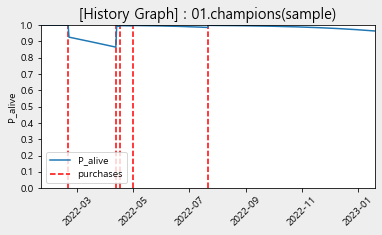

In [325]:
mpl.rc('figure', figsize=(6, 3))
fig = plt.figure( facecolor='#eeeeee')

sample_list =  list(rfm2[rfm2.segment == '01.champions']['UNFY_MMB_NO'].sample(3))
days_since_birth = 365

for no_ in sample_list:
    plt.subplot(1,3, int(sample_list.index(no_))+1)
    sp_trans = df_all[df_all.UNFY_MMB_NO == no_ ]
    plot_history_alive(bgf, days_since_birth, sp_trans, 'REG_DTM')
    plt.xticks(rotation=45)
    plt.title('[History Graph] : 01.champions(sample)',fontsize='x-large')
    
# plt.show()

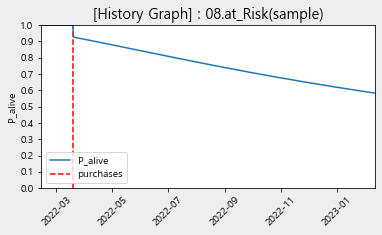

In [331]:
mpl.rc('figure', figsize=(6, 3))
fig = plt.figure( facecolor='#eeeeee')

sample_list =  list(rfm2[rfm2.segment == '08.at_Risk']['UNFY_MMB_NO'].sample(3))
days_since_birth = 365

for no_ in sample_list:
    plt.subplot(1,3, int(sample_list.index(no_))+1)
    sp_trans = df_all[df_all.UNFY_MMB_NO == no_ ]
    plot_history_alive(bgf, days_since_birth, sp_trans, 'REG_DTM')
    plt.xticks(rotation=45)
    plt.title('[History Graph] : 08.at_Risk(sample)',fontsize='x-large')
    

In [326]:
days_since_birth = 300
sp_trans = df_A.loc[df_A.UNFY_MMB_NO == 544040]
plot_history_alive(bgf, days_since_birth, sp_trans, 'REG_DTM')
plt.xticks(rotation=45)
plt.title('[History Graph] : 08.at_Risk(sample)',fontsize='x-large')
plt.show()

ValueError: min() arg is an empty sequence

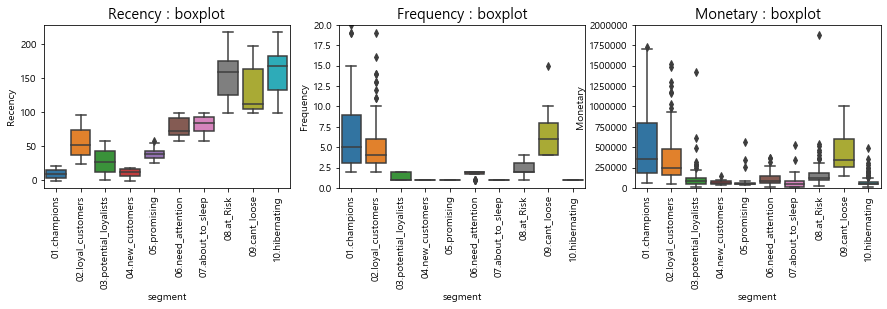

In [277]:
fig = plt.figure(figsize=(15, 3))

ax = plt.subplot2grid((1, 3), (0, 0), colspan=1)
# ax.set_ylim([0, 300])
sns.boxplot(x="segment", y="Recency", data=rfm, order=sorted(rfm.segment.unique()) ) 
plt.title('Recency : boxplot',fontsize='x-large')
plt.xticks(rotation=90)

ax = plt.subplot2grid((1, 3), (0, 1), colspan=1)
ax.set_ylim([0, 20])
sns.boxplot(x="segment", y="Frequency", data=rfm, order=sorted(rfm.segment.unique()) ) 
plt.title('Frequency : boxplot',fontsize='x-large')
plt.xticks(rotation=90)

ax = plt.subplot2grid((1, 3), (0, 2), colspan=1)
ax.set_ylim([0, 2000000])
sns.boxplot(x="segment", y="Monetary",data=rfm, order=sorted(rfm.segment.unique()) )
plt.title('Monetary : boxplot',fontsize='x-large')
plt.xticks(rotation=90)

plt.show()